# Product recommendation engine
---
![](resources/groceries.jpg)

## Main objective:
---
Imagine we are a grocery store owner, and we are trying to maximize the purchases of our customers per visit. 

A first strategy that comes to our mind is placing products next to each other that are usually bought together.

Since we have succesfully completed a Data Science task in the past we immediately realize that this problem can be formulated as a recommendation task.


The machine learning part has the following goal:


Essentially we will try to predict the last item of a customers purchase list, given all the other items that he has already in his shopping basket. Those predictions are a helpful first heuristic for the placement of certain products in our grocery store. 

Thus we start collecting the purchase histories of past customers and start writing down the following steps needed, to build our recommendation pipeline:


### Plan of attack:
1. Load the customer purchase data, located in 'data/training_data.csv', 'data/training_labels.csv'
    - Note on the dataset: Each row in each of the data files refers to one 'incomplete' item-list of a customers purchase.
    - The labels represent the item that was purchased by the customer in addition to the items in the dataset
    
    
2. Plot the following statistics:
    - histogram of 10 most purchased products
    - pie chart of all product purchase frequencies
    - which other interesting plots can you think of ? -> extra points



3. Compute and present the following results(you are free to choose any method to present your results):
    - Find the pair of products, that are bought together the most
    - How many customers purchased all the products 
    - Which product was the least purchased ?


4. Transform it into a Machine learning-classifier digestable format:
    - Machine learning algorithms consume data, that has a unified format!
    - For example it should look like that:
    
    
    | feature 1(e.g. product/grocery): | feature 2: | ... | feature N: |
    | "apple"                          | "banana"   | ... | mango      |
    --------------------------------------------------------------------
    | no                               | yes        | ... | no         | <- customer 1: purchased only banana 
    --------------------------------------------------------------------
    | yes                              | yes        | ... | yes        | <- customer 2: purchased all 3 shown
    -------------------------------------------------------------------- 
                                .
                                .
                                .
    --------------------------------------------------------------------
    | no                              | no         | ... | no          | <- customer N: purchased nothing
    --------------------------------------------------------------------
    


5. Train your model on the training set, and predict an item for the each row in the test set(DON'T change the order of the test set):
    - Item-predictions should be in the original string format(=item name)



6. Save the predictions for the test set in a csv-file


### Note on implementation:
- You are free to use any classification algorithm that you want. If you find better recommendation approaches on the web(there certainly are better, but also more involved ones), you are free to use those. The main goal though will be to 
- Try to implement classes


### Note on grading:
- End result = 25%
- Clean code(e.g. classes instead of script like functions etc.) = 25 %
- Documentation = 25%
- Usage of numpy, pandas, pyplot etc. functions for faster computation = 25%

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch, torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import seaborn as sns
import nltk
nltk.download('stopwords')
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 90

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train_x = pd.read_csv('data/training_data.csv', header=None)
test_x = pd.read_csv('data/test_data.csv', header=None)
train_y = pd.read_csv('data/training_labels.csv', header=None)

In [7]:
#pre-handle, remove meaningless lines, add columns and index, onehot coding
data = train_x
data.dropna(axis=0, how='all', inplace=True)
new_data = pd.get_dummies(data, prefix='')
nn_data = new_data.groupby(axis = 1, level = 0).sum()
nn_data.columns = nn_data.columns.str.replace("_", "")
nn_data.index = ["Custom No." + str(index) for index in range(5171)]
nn_data.to_csv("new_data.csv")
labels = train_y.iloc[data.index,:]
labels.index = ["Custom No." + str(index) for index in range(5171)]
labels.to_csv("new_labels.csv")

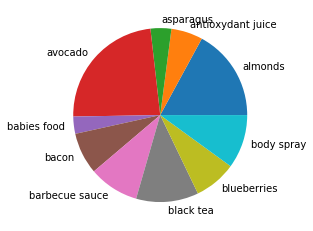

In [8]:
#piechart plot
mpie = nn_data.apply(sum)[:10]
plt.pie(x=mpie.values, labels=mpie.index)
plt.show()

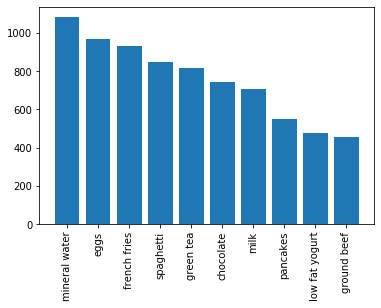

In [9]:
#historgram
number = nn_data.apply(sum).sort_values(ascending = False)[:10]
plt.bar([0,1,2,3,4,5,6,7,8,9], number.values)
plt.xticks([0,1,2,3,4,5,6,7,8,9], number.index, rotation='90')
plt.show()

In [10]:
#old version get best pair, slow, provide less info
def OldGetPair(nn_data):
    adata = np.asarray(nn_data)*0.5
    best_comb = 0
    best = [[]]
    for sft in range(59):
        ndata = np.hstack((adata[:,sft+1:], adata[:,:sft+1]))
        ndata = ((np.floor(ndata + adata)).sum(axis=0))
        dmax = ndata.max()
        if best_comb < dmax:
            best_comb = dmax
            best = [[ndata.argmax(), sft+1]]
        elif best_comb == dmax:
            best.append([[ndata.argmax(), sft+1]])
    return best

best = np.asarray(OldGetPair(nn_data))



In [11]:
#new version faster
def GetPairMap(nn_data):
    adata = np.asarray(nn_data)*0.5
    pairs = np.ones([119,119])
    order0 = list(range(119))
    for sft in range(1,119):
        ndata = np.hstack((adata[:,sft:], adata[:,:sft]))
        order1 = list(range(sft,119)) + list(range(sft))
        ndata = ((np.floor(ndata + adata)).sum(axis=0))
        pairs[order0,order1] = ndata
    return np.array(pairs)

PairMap = GetPairMap(nn_data)
mask = np.asarray([PairMap == PairMap.max()])

mask[0].nonzero()


(array([71, 99], dtype=int64), array([99, 71], dtype=int64))

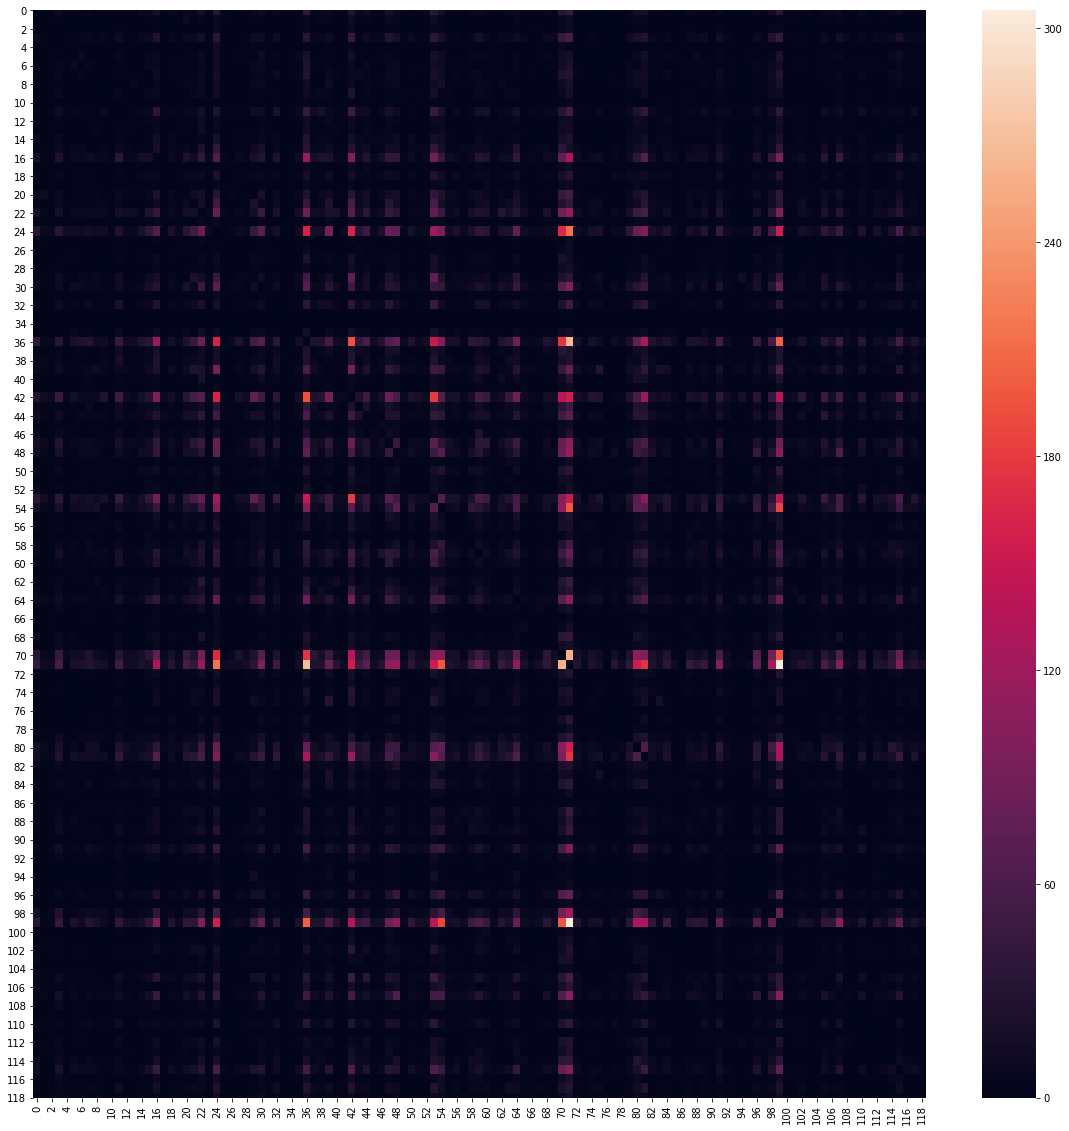

In [26]:
#heat map for connection 
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(PairMap, vmax=305)

In [12]:
#least bought item
least_item = nn_data.sum(axis=0).idxmin()
least_item

'water spray'

In [17]:
nn_data

,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
Custom No.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Custom No.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Custom No.5166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.5167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.5168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Custom No.5169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# Get the data

###### GET THE TRAIN TARGET UNIQUE LIST #####
def Get_train_targets(train_y):
    train_y_dummies = pd.get_dummies(list(train_y[0]))

    # get a dictionary
    product_dict = {}
    for i,product in enumerate(nn_data.columns):
        product_dict[product] = i

    #rename the dummies
    train_y_idx = train_y_dummies.rename(columns=product_dict)

    #return the idxmax value
    train_targets = train_y_idx.idxmax(axis=1)
    
    return train_targets

#### GET THE TRAINING DATAPOINT #####
def Get_train_datas(train_x):
    #### receive one hot data!!!! #####
    one_hot_training_data = train_x
    return one_hot_training_data

class CustomDataset():

    def __init__(self, data, labels):

        self.target = torch.LongTensor(labels)
        self.data = torch.Tensor(np.asarray(data))
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]
    
#### BATCH THE DATAPOINT ####
def Get_batch(one_hot_training_data, train_targets, size):
    # zip the data and target
    training_data = CustomDataset(one_hot_training_data,train_targets)
    # batch the data point
    train_loader = torch.utils.data.DataLoader(training_data, batch_size=size, shuffle=True)
    return train_loader

In [95]:
train_loader = Get_batch(Get_train_datas(nn_data), Get_train_targets(train_y), 2)

In [96]:
class Neural_Network(torch.nn.Module):
    
    def __init__(self, input_dim, num_classes):
        
        super(Neural_Network, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        self.layer1 = torch.nn.Linear(self.input_dim, 50)
        
        self.layer2 = torch.nn.Linear(50, 100)
        
        self.layer3 = torch.nn.Linear(100, self.num_classes)
        
    def forward(self, x):
        
        x = self.layer1(x.view(-1, self.input_dim))
        x = F.sigmoid(x)
        
        x = self.layer2(x)
        x = F.sigmoid(x)
        
        x = self.layer3(x)
        
        return x

In [103]:
neural_net = Neural_Network(119, 119)
optimizer = torch.optim.SGD(params=neural_net.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()

In [104]:
# training loop:

for epoch in range(10):
    running_loss = 0.0
    
    for i, (x, y) in enumerate(train_loader, 1):
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        
        # forward pass
        predictions = neural_net.forward(x)
                
        # backward pass + optimization step
        loss = loss_fn(predictions, y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        if i % 1000 == 0:
            print(f'Epoch: {epoch}, loss: {running_loss / i}')
        
    print(f'Loss after epoch: {epoch} = {running_loss / len(train_loader)}')

D:\software\anaconda\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, loss: 3.940009888410568
Epoch: 0, loss: 3.876846750676632
Loss after epoch: 0 = 3.8671924500435892
Epoch: 1, loss: 3.8105248737335207
Epoch: 1, loss: 3.8033562346696854
Loss after epoch: 1 = 3.797426295852071
Epoch: 2, loss: 3.7840201201438903
Epoch: 2, loss: 3.7792199765443804
Loss after epoch: 2 = 3.782001823763099
Epoch: 3, loss: 3.7828433384895326
Epoch: 3, loss: 3.77092112493515
Loss after epoch: 3 = 3.7763576564729813
Epoch: 4, loss: 3.7772380504608156
Epoch: 4, loss: 3.7629122656583784
Loss after epoch: 4 = 3.7699928266174187
Epoch: 5, loss: 3.750690171003342
Epoch: 5, loss: 3.749459621787071
Loss after epoch: 5 = 3.765203363380963
Epoch: 6, loss: 3.7655511462688445
Epoch: 6, loss: 3.7693180599212646
Loss after epoch: 6 = 3.764005467583759
Epoch: 7, loss: 3.794940309524536
Epoch: 7, loss: 3.7696611084938048
Loss after epoch: 7 = 3.763951618359795
Epoch: 8, loss: 3.7182795243263245
Epoch: 8, loss: 3.7521373344659805
Loss after epoch: 8 = 3.7600750692667004
Epoch: 9, los

In [106]:
correct = 0
total = 0
with torch.no_grad():
    for datapoint in train_loader:
        data, labels = datapoint
        outputs = neural_net(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

D:\software\anaconda\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 10000 test images: 7 %
